In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets(".", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./t10k-labels-idx1-ubyte.gz


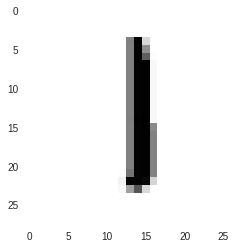

In [3]:
plt.figure().gca().grid(False)
plt.imshow(mnist.train.images[12].reshape(28, 28), cmap="Greys")

In [0]:
def discriminator(images, reuse=False):
    if reuse:
        tf.get_variable_scope().reuse_variables()

    ####################### Convolutional Layer 1 ##############################
    d_w1 = tf.get_variable("d_w1", [5, 5, 1, 32],
                       initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable("d_b1", [32],
                           initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1],
                      padding="SAME")
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                        padding="SAME")

    ####################### Convolutional Layer 2 ##############################
    d_w2 = tf.get_variable("d_w2", [5, 5, 32, 64],
                       initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable("d_b2", [64],
                           initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1],
                      padding="SAME")
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                        padding="SAME")
    
    ########################### Dense Layer 1 ##################################
    d_w3 = tf.get_variable("d_w3", [7 * 7 * 64, 1024],
                       initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable("d_b3", [1024],
                            initializer=tf.constant_initializer(0))
    # flatten
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3) + d_b3
    d3 = tf.nn.relu(d3)
    
    ########################### Dense Layer 2 ##################################
    d_w4 = tf.get_variable("d_w4", [1024, 1],
                       initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable("d_b4", [1],
                            initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4
    # this is unscaled, so it's not probability or something
    return d4

In [0]:
def generator(z, batch_size, z_dim):
    """ Takes in random values, and generates images """
    ################### Dense Layer 1 + Batch Normalization ####################
    g_w1 = tf.get_variable("g_w1", [z_dim, 3136], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable("g_b1", [3136],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope="bn1")
    g1 = tf.nn.relu(g1)

    ############## Convolutional Layer 1  + Batch Normalization ################

    g_w2 = tf.get_variable("g_w2", [3, 3, 1, z_dim/2], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable("g_b2", [z_dim/2],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding="SAME")
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope="bn2")
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    ############## Convolutional Layer 2  + Batch Normalization ################
    g_w3 = tf.get_variable("g_w3", [3, 3, z_dim/2, z_dim/4], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable("g_b3", [z_dim/4],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding="SAME")
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope="bn3")
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    ############## Convolutional Layer 3  + Batch Normalization ################
    g_w4 = tf.get_variable("g_w4", [1, 1, z_dim/4, 1], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable("g_b4", [1],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding="SAME")
    g4 = g4 + g_b4
    # output dimensions: batch_size x 28 x 28 x 1
    # the reason we're taking sigmoid is to have crispier image
    g4 = tf.nn.sigmoid(g4)
    return g4

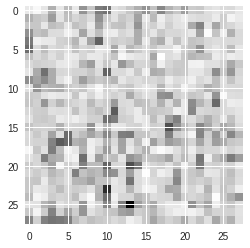

In [6]:
def print_random_image():
    z_dimensions = 100
    z_placeholder = tf.placeholder(tf.float32, shape=[None, z_dimensions])
    noisy_image = generator(z_placeholder, 1, z_dimensions)
    z_batch = np.random.normal(0, 1, [1, z_dimensions])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        generated_image = sess.run(noisy_image, feed_dict={z_placeholder: z_batch})
        generated_image = generated_image.reshape([28, 28])
        plt.imshow(generated_image, cmap="Greys")
print_random_image()

In [0]:
tf.reset_default_graph()

In [0]:
# Setup Training
z_dimensions = 100
batch_size = 50
# z_placeholder is for feeding in the noise to the GAN
z_placeholder = tf.placeholder(tf.float32, shape=[None, z_dimensions],
                               name="z_placeholder")
# x_placeholder will feed any image to the disciminator. It can be
# from MNIST database, or from our generator function.
x_placeholder = tf.placeholder(tf.float32, shape=[None, 28, 28, 1],
                               name="x_placeholder")
# Gz will hold the newly generated images from generator
Gz = generator(z_placeholder, batch_size, z_dimensions)
# Dx will hold the probabilities of the actual MNIST images

# Dg will hold the probabilities of the new generated images
Dg = discriminator(Gz)
Dx = discriminator(x_placeholder, reuse=True)

In [0]:
# Discriminator Loss
d_loss_real = tf.reduce_mean(tf.nn
                    .sigmoid_cross_entropy_with_logits(logits=Dx, 
                                                       labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn
                    .sigmoid_cross_entropy_with_logits(logits=Dg,
                                                       labels=tf.zeros_like(Dg)))

In [0]:
# Generator Loss
g_loss = tf.reduce_mean(tf.nn
                     .sigmoid_cross_entropy_with_logits(logits=Dg,
                                                       labels=tf.ones_like(Dg)))

In [11]:
# While training Generator, we want to keep the Discriminator variables
# constant. And same goes for training Discriminator

tvars = tf.trainable_variables()
d_vars = [var for var in tvars if "d_" in var.name]
g_vars = [var for var in tvars if "g_" in var.name]

print("Discriminator vars: {}".format([var.name for var in d_vars]))
print("Generator vars: {}".format([var.name for var in g_vars]))

Discriminator vars: ['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
Generator vars: ['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [0]:
# Train the Discriminator
with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE): 
    d_trainer_real = tf.train.AdamOptimizer(learning_rate=0.0003) \
                             .minimize(d_loss_real, var_list=d_vars)

    d_trainer_fake = tf.train.AdamOptimizer(learning_rate=0.0003) \
                             .minimize(d_loss_fake, var_list=d_vars)

    # Train the Generator
    g_trainer = tf.train.AdamOptimizer(learning_rate=0.0001) \
                        .minimize(g_loss, var_list=g_vars)

In [0]:
saver = tf.train.Saver()

In [17]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    # Train Discriminator first
    sess.run(init)
#     saver.restore(sess, "/content/gan/model")
    for i in range(1000):
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        real_image_batch = mnist.train.next_batch(batch_size)[0] \
                                      .reshape([batch_size, 28, 28, 1])
        _, _, d_loss_real_val, d_loss_fake_val = \
                sess.run([d_trainer_real, d_trainer_fake, d_loss_real, 
                          d_loss_fake],
                         feed_dict={x_placeholder: real_image_batch,
                                    z_placeholder: z_batch})
        if i % 50 == 0:
            print("Iteration: {0} \tLoss Real: {1:.5f}\tLoss Fake: {2:.5f}"
                       .format(i, d_loss_real_val, d_loss_fake_val))
    saver.save(sess, "/content/gan/model")

Iteration: 0 	Loss Real: 0.69308	Loss Fake: 0.70976
Iteration: 50 	Loss Real: 0.30527	Loss Fake: 0.77538
Iteration: 100 	Loss Real: 0.03286	Loss Fake: 0.08415
Iteration: 150 	Loss Real: 0.00802	Loss Fake: 0.02482
Iteration: 200 	Loss Real: 0.00065	Loss Fake: 0.00038
Iteration: 250 	Loss Real: 0.00034	Loss Fake: 0.00027
Iteration: 300 	Loss Real: 0.00187	Loss Fake: 0.00017
Iteration: 350 	Loss Real: 0.00008	Loss Fake: 0.00012
Iteration: 400 	Loss Real: 0.00009	Loss Fake: 0.00011
Iteration: 450 	Loss Real: 0.00043	Loss Fake: 0.00011
Iteration: 500 	Loss Real: 0.00009	Loss Fake: 0.00007
Iteration: 550 	Loss Real: 0.00003	Loss Fake: 0.00007
Iteration: 600 	Loss Real: 0.00009	Loss Fake: 0.00006
Iteration: 650 	Loss Real: 0.00002	Loss Fake: 0.00004
Iteration: 700 	Loss Real: 0.00005	Loss Fake: 0.00003
Iteration: 750 	Loss Real: 0.00005	Loss Fake: 0.00003
Iteration: 800 	Loss Real: 0.00008	Loss Fake: 0.00004
Iteration: 850 	Loss Real: 0.00001	Loss Fake: 0.00003
Iteration: 900 	Loss Real: 0.00

In [27]:
# Train generator and discriminator at the same
with tf.Session() as sess:
    steps = 100000
    saver.restore(sess, "/content/gan/model")
    for i in range(steps):
        real_image_batch = mnist.train.next_batch(batch_size)[0] \
                                      .reshape([-1, 28, 28, 1])
        # Train Discriminator
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        _, _, d_loss_real_val, d_loss_fake_val = \
            sess.run(
                [d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                feed_dict={x_placeholder: real_image_batch, 
                           z_placeholder: z_batch}
            )
        # Train Generator
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        _, g_loss_val = sess.run([g_trainer, g_loss], 
                                 feed_dict={z_placeholder: z_batch})

        # Debug info
        if i % 1000 == 0:
            print("Iteration: {0}\tDLoss Real: {1:.4f}\tDLoss Fake: {2:.4f}"
                  "\tGLoss: {3:.4f}".format(i, d_loss_real_val, d_loss_fake_val,
                                           g_loss_val))
    saver.save(sess, "/content/gan/model")
    

INFO:tensorflow:Restoring parameters from /content/gan/model
Iteration: 0	DLoss Real: 0.0274	DLoss Fake: 3.5510	GLoss: 6.4086
Iteration: 1000	DLoss Real: 0.3001	DLoss Fake: 4.8100	GLoss: 1.3463
Iteration: 2000	DLoss Real: 0.0001	DLoss Fake: 11.8316	GLoss: 0.2900
Iteration: 3000	DLoss Real: 7.5022	DLoss Fake: 0.0012	GLoss: 2.1869
Iteration: 4000	DLoss Real: 1.7415	DLoss Fake: 1.0484	GLoss: 2.3957
Iteration: 5000	DLoss Real: 4.0374	DLoss Fake: 0.6165	GLoss: 1.9592
Iteration: 6000	DLoss Real: 0.2387	DLoss Fake: 2.6595	GLoss: 6.1472
Iteration: 7000	DLoss Real: 1.0244	DLoss Fake: 7.2106	GLoss: 2.8867
Iteration: 8000	DLoss Real: 0.6583	DLoss Fake: 8.4785	GLoss: 2.7842
Iteration: 9000	DLoss Real: 0.6970	DLoss Fake: 6.2023	GLoss: 6.7081
Iteration: 10000	DLoss Real: 3.8503	DLoss Fake: 3.5546	GLoss: 0.1147
Iteration: 11000	DLoss Real: 3.2922	DLoss Fake: 4.9207	GLoss: 0.4871
Iteration: 12000	DLoss Real: 4.9237	DLoss Fake: 4.3103	GLoss: 2.2280
Iteration: 13000	DLoss Real: 23.5717	DLoss Fake: 0.031

Iteration: 52000	DLoss Real: 21.1157	DLoss Fake: 5.5879	GLoss: 1.3915
Iteration: 53000	DLoss Real: 7.5539	DLoss Fake: 20.7839	GLoss: 2.6277
Iteration: 54000	DLoss Real: 4.9874	DLoss Fake: 34.1384	GLoss: 1.1870
Iteration: 55000	DLoss Real: 3.4666	DLoss Fake: 34.5087	GLoss: 8.3575
Iteration: 56000	DLoss Real: 25.1974	DLoss Fake: 12.5859	GLoss: 5.3906
Iteration: 57000	DLoss Real: 27.1813	DLoss Fake: 14.4489	GLoss: 4.2580
Iteration: 58000	DLoss Real: 17.6728	DLoss Fake: 19.9264	GLoss: 9.2541
Iteration: 59000	DLoss Real: 19.6593	DLoss Fake: 17.6911	GLoss: 2.5688
Iteration: 60000	DLoss Real: 26.1740	DLoss Fake: 9.4944	GLoss: 9.2890
Iteration: 61000	DLoss Real: 20.0087	DLoss Fake: 14.4073	GLoss: 3.5832
Iteration: 62000	DLoss Real: 18.1446	DLoss Fake: 17.8708	GLoss: 1.4620
Iteration: 63000	DLoss Real: 18.1176	DLoss Fake: 20.5427	GLoss: 3.9803
Iteration: 64000	DLoss Real: 13.6793	DLoss Fake: 33.1709	GLoss: 1.0754
Iteration: 65000	DLoss Real: 15.2692	DLoss Fake: 23.2309	GLoss: 1.2370
Iteration: 

INFO:tensorflow:Restoring parameters from /content/gan/model


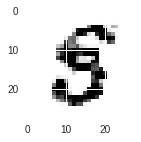

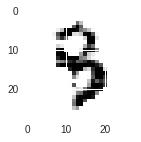

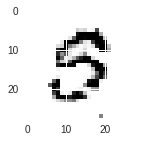

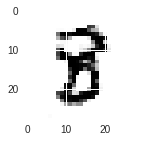

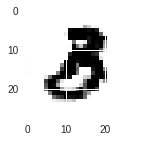

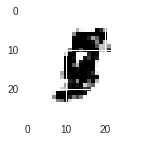

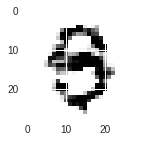

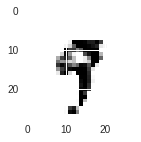

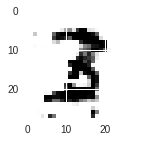

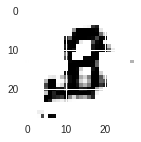

In [28]:
with tf.Session() as sess:
    saver.restore(sess, "/content/gan/model")
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    generated_image = generator(z_placeholder, 10, z_dimensions)
    image = sess.run(generated_image, feed_dict={z_placeholder: z_batch})
    images = image.reshape([-1, 28, 28])
    for image_val in images:
        plt.figure(figsize=(2, 2))
        plt.imshow(image_val, cmap="Greys")
        plt.show()

In [0]:
!tar -cf gan.tar gan


In [30]:
!curl --upload-file /content/gan.tar https://transfer.sh/gan.tar

https://transfer.sh/O9qXJ/gan.tar

In [0]:
# https://transfer.sh/O9qXJ/gan.tar

In [34]:
! curl --output gan.tar https://transfer.sh/Tsi6K/gan.tar


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66.2M  100 66.2M    0     0  1996k      0  0:00:34  0:00:34 --:--:-- 4001k


In [42]:
! ls /content/gan/

checkpoint  model.data-00000-of-00001  model.index  model.meta
